In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
EXTRA_SMALL_SIZE = 16
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24
plt.rcParams['lines.linewidth'] = 2.5

In [3]:
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
MAX_DATE = np.datetime64('2021-08-30')

In [5]:
# https://data.humdata.org/dataset/c87c4508-9caf-4959-bf06-6ab4855d84c6
# See process_positive_rate_world.ipynb
df_test_world = pd.read_csv('datasets/test-rate-processed.csv', names=['location', 'date', 'positive_rate'])
df_test_world['date'] = pd.to_datetime(df_test_world['date'])
df_test_world = df_test_world[df_test_world['date'] < MAX_DATE]
df_test_world

,location,date,positive_rate
0,Albania,2021-01-01,0.233840
1,Albania,2021-01-02,0.235579
2,Albania,2021-01-03,0.235195
3,Albania,2021-01-04,0.234737
4,Albania,2021-01-05,0.234179
...,...,...,...
23675,Average,2021-06-30,0.061074
23676,Average,2021-07-01,0.067215
23677,Average,2021-07-02,0.075195
23678,Average,2021-07-03,0.000000


In [6]:
# https://www.canada.ca/en/public-health/services/diseases/2019-novel-coronavirus-infection.html#a1
# See process_positive_rate_canada.ipynb
df_test_can = pd.read_csv('datasets/can_covid19_processed.csv', names=['location', 'date', 'positive_rate'])
df_test_can['date'] = pd.to_datetime(df_test_can['date'])
df_test_can = df_test_can[df_test_can['date'] < MAX_DATE]
df_test_can

,location,date,positive_rate
0,Ontario,2020-01-31,NaN
1,British Columbia,2020-01-31,NaN
2,Ontario,2020-02-08,NaN
3,British Columbia,2020-02-08,NaN
4,Ontario,2020-02-16,NaN
...,...,...,...
6315,Nova Scotia,2021-07-06,NaN
6316,Prince Edward Island,2021-07-06,NaN
6317,Yukon,2021-07-06,NaN
6318,Northwest Territories,2021-07-06,NaN


In [7]:
df_test = pd.concat([df_test_world, df_test_can])
df_test

,location,date,positive_rate
0,Albania,2021-01-01,0.233840
1,Albania,2021-01-02,0.235579
2,Albania,2021-01-03,0.235195
3,Albania,2021-01-04,0.234737
4,Albania,2021-01-05,0.234179
...,...,...,...
6315,Nova Scotia,2021-07-06,NaN
6316,Prince Edward Island,2021-07-06,NaN
6317,Yukon,2021-07-06,NaN
6318,Northwest Territories,2021-07-06,NaN


In [8]:
blacklist = ['Taiwan*', 'Nunavut', 'Luxembourg']
nodes = np.array(list(set(df_test['location'].unique()).difference(set(blacklist))))
dates = pd.to_datetime(sorted(df_test['date'].unique()))

In [9]:
def plot_interpolated_positive_rate(ax, idx, x, y, pred_x, pred_y, node):
    ax =  ax[int(idx/6), idx % 6]
    ax.plot(x, y, 'o')
    ax.plot(pred_x, pred_y, '-')
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    ax.set_title(node)
    ax.get_xaxis().set_visible(False)

In [10]:
def get_rates():
    xs = []
    ys = []
    rates = np.zeros(shape=(nodes.shape[0], len(dates)))
    col, row = 6,  math.ceil(rates.shape[0]/6) 
    fig, ax = plt.subplots(row, col, figsize=(col* 6, row * 4))
    for n_idx, node in enumerate(nodes): 
        df_node = df_test[df_test['location'] == node]
        y_nan = np.isnan(df_node['positive_rate']) 
        x = df_node['date'][~y_nan].dt.dayofyear.to_list()
        y = df_node['positive_rate'][~y_nan].to_list()
        if x[0] > 0:
#             print("Data points less than expected (lower):", node)
            x0 = np.linspace(0, x[0] , num=int(x[0]/20), endpoint=False)
            x = np.append(x0, x)
            y0 = np.zeros(len(x0))
            y = np.append(y0, y)
        if x[-1] < dates[-1].dayofyear:
#             print("Data points less than expected (higher):", node)
            x = np.append(x, dates[-1].dayofyear)
            y = np.append(y, y[y > 0.0][-1])
        f = interp1d(x, y, kind='slinear', fill_value="extrapolate")
        rates[n_idx] = [max(r, 0.0) for r in f(dates.dayofyear)]
        xs.append(x)
        ys.append(y)
        plot_interpolated_positive_rate(ax, n_idx, x, y, dates.dayofyear, rates[n_idx], node)
    return np.transpose(rates), xs, ys

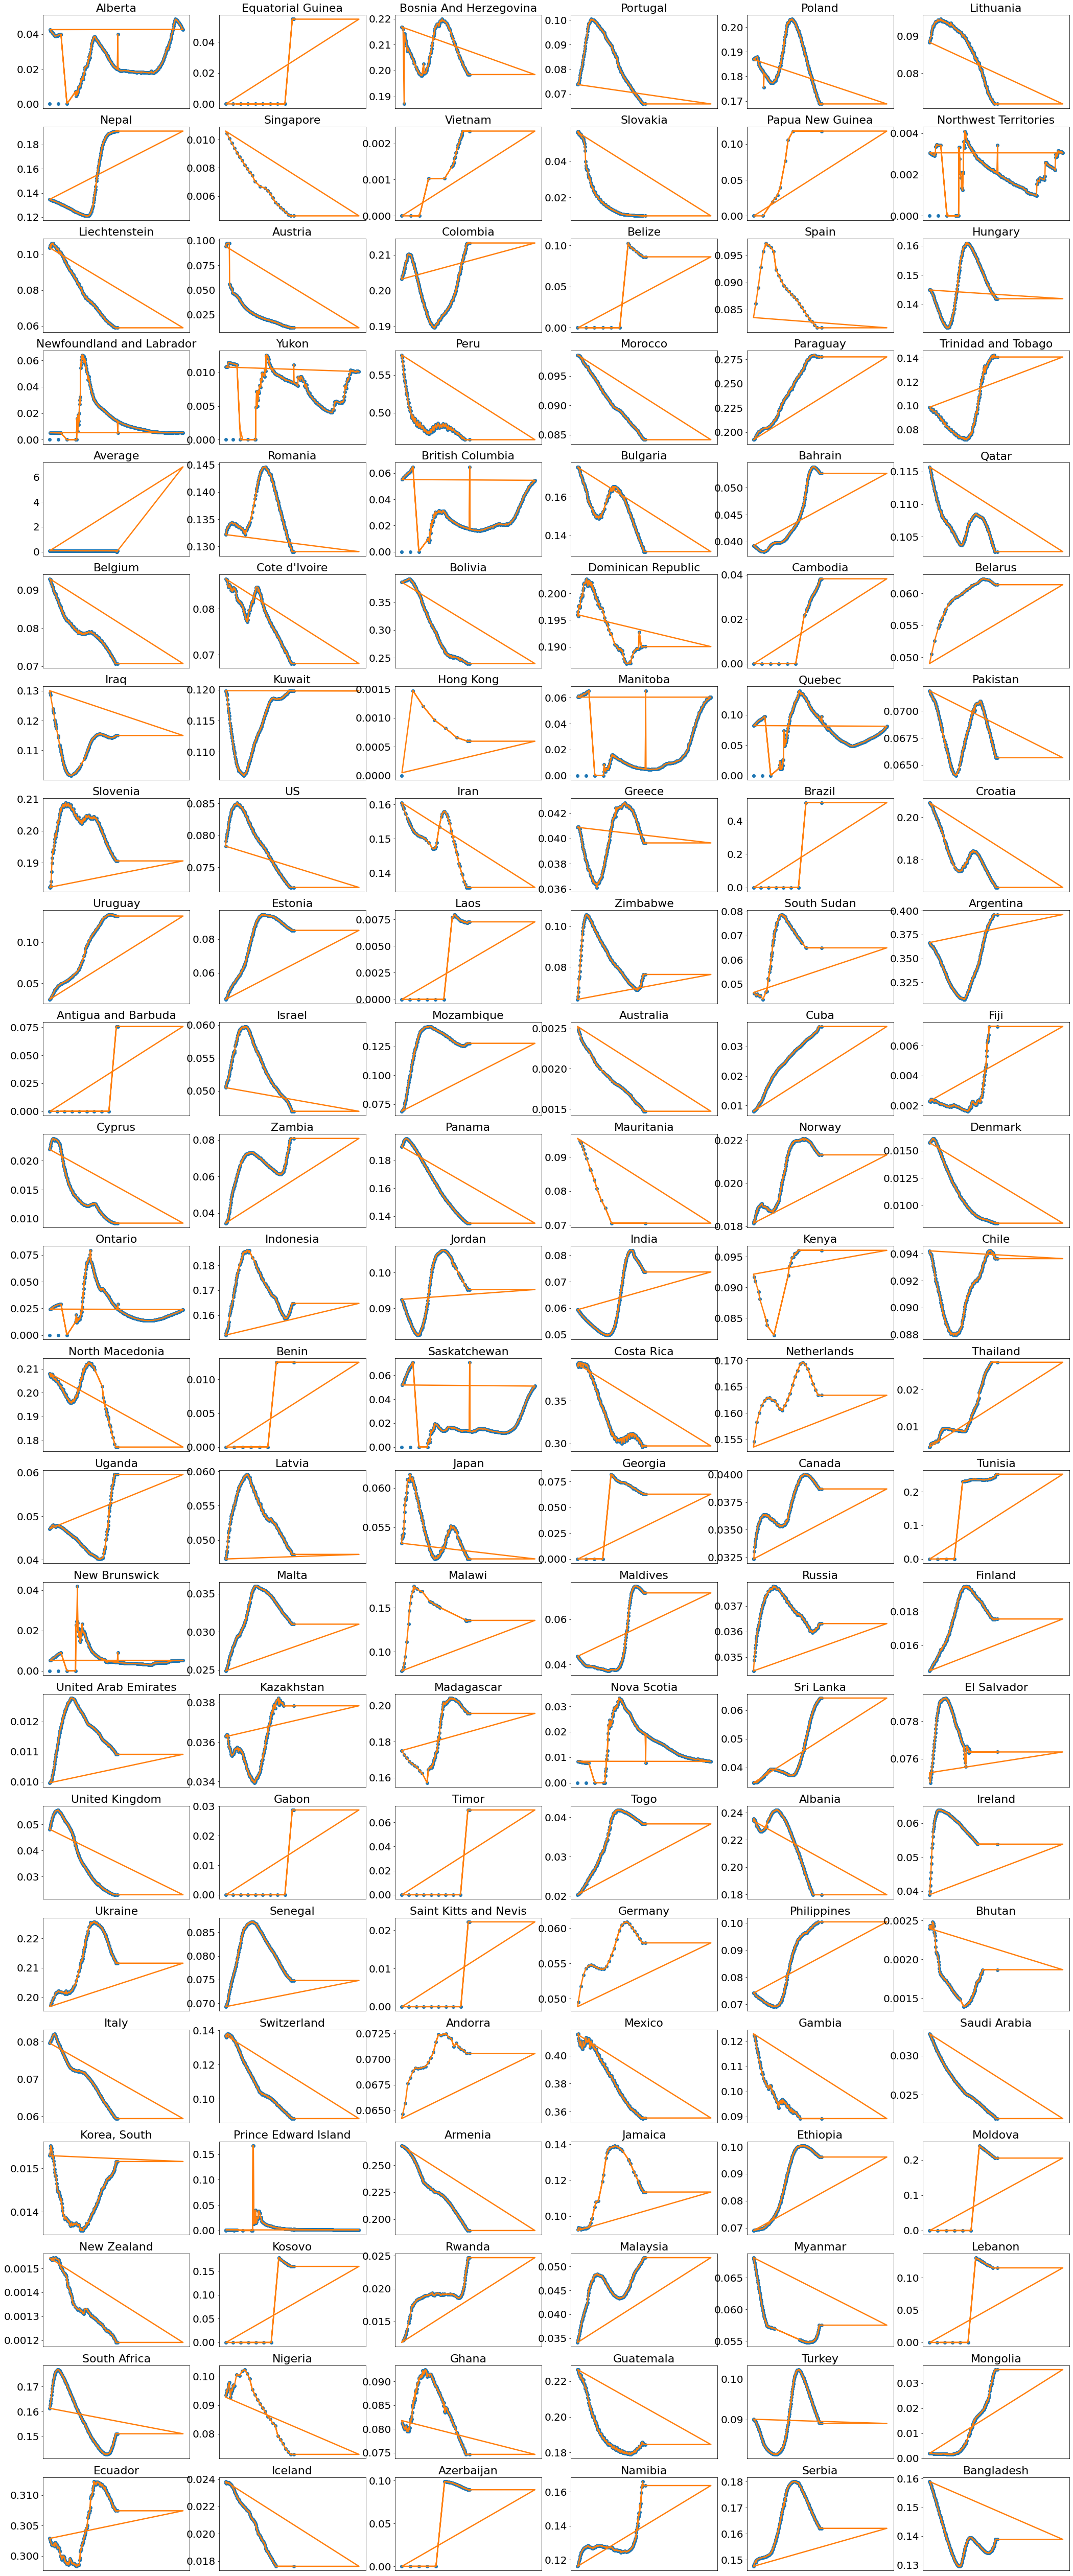

In [11]:
rates, xs, ys = get_rates()

In [12]:
print(rates.shape)
print(len(xs))
print(len(ys))

(499, 138)
138
138


In [13]:
df_rates = pd.DataFrame(rates, index=dates, columns=nodes)

In [14]:
df_rates

,Alberta,Equatorial Guinea,Bosnia And Herzegovina,Portugal,Poland,Lithuania,Nepal,Singapore,Vietnam,Slovakia,...,Ghana,Guatemala,Turkey,Mongolia,Ecuador,Iceland,Azerbaijan,Namibia,Serbia,Bangladesh
2020-01-31,0.039833,0.000000,0.204690,0.098403,0.181132,0.094532,0.130834,0.009129,0.000000,0.031977,...,0.084981,0.209622,0.083609,0.001751,0.299978,0.022792,0.000000,0.127726,0.151009,0.146651
2020-02-08,0.020323,0.000000,0.201793,0.100235,0.179606,0.094025,0.129751,0.008783,0.000000,0.026459,...,0.087921,0.202822,0.082572,0.001850,0.299954,0.022372,0.000000,0.127211,0.151584,0.143192
2020-02-16,0.000813,0.000000,0.199270,0.099661,0.177602,0.093623,0.128508,0.008471,0.000000,0.022892,...,0.089763,0.198460,0.081956,0.001729,0.298738,0.022108,0.000000,0.127398,0.152295,0.139757
2020-02-21,0.001402,0.000000,0.198562,0.099104,0.177467,0.093445,0.127793,0.008256,0.000111,0.021031,...,0.091102,0.196686,0.081639,0.001655,0.298639,0.021970,0.000000,0.127951,0.153416,0.137740
2020-02-24,0.002303,0.000000,0.198024,0.098335,0.177439,0.093031,0.127317,0.008137,0.000237,0.020648,...,0.090919,0.193941,0.081542,0.001616,0.299125,0.021872,0.000000,0.128318,0.154520,0.136657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-02,0.020490,0.054822,0.198425,0.065969,0.168812,0.071722,0.191170,0.004597,0.002338,0.009823,...,0.074639,0.184531,0.089014,0.035454,0.307421,0.017610,0.089232,0.163752,0.162045,0.138829
2021-07-03,0.020134,0.054822,0.198425,0.065969,0.168812,0.071722,0.191170,0.004597,0.002338,0.009823,...,0.074639,0.184531,0.089014,0.035454,0.307421,0.017610,0.089232,0.163752,0.162045,0.138829
2021-07-04,0.020005,0.054822,0.198425,0.065969,0.168812,0.071722,0.191170,0.004597,0.002338,0.009823,...,0.074639,0.184531,0.089014,0.035454,0.307421,0.017610,0.089232,0.163752,0.162045,0.138829
2021-07-05,0.020005,0.054822,0.198425,0.065969,0.168812,0.071722,0.191170,0.004597,0.002338,0.009823,...,0.074639,0.184531,0.089014,0.035454,0.307421,0.017610,0.089232,0.163752,0.162045,0.138829


In [15]:
def plot_rates(target_countries, df, label, filename):
    fig = plt.figure(facecolor='w', figsize=(16, 8))
    ax = fig.add_subplot(111)
    for c in target_countries:
        rate = df[c].to_list()
        date = df[c].index
        node_idx = np.argwhere(nodes == c)[0][0]
        x = [df[c].index[int(i - 1)] for i in xs[node_idx]]
        ax.scatter(x, ys[node_idx])
        ax.plot(date, rate, '--', label=c)
    ax.set_xlabel('Date')
    ax.set_ylabel('Positive Rate')
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end, 14))
    ax.xaxis.set_tick_params(rotation=30)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    plt.savefig(filename, bbox_inches='tight')

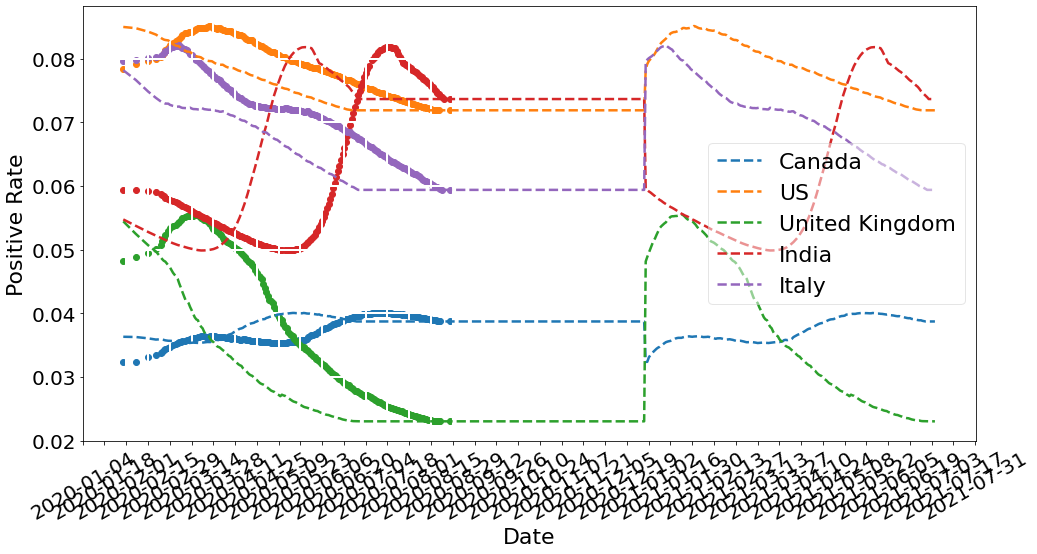

In [16]:
target_countries = ['Canada', 'US', 'United Kingdom', 'India', 'Italy']
plot_rates(target_countries, df_rates, "positive_rate", 'graphs/flights/positive_rates_countries.png')

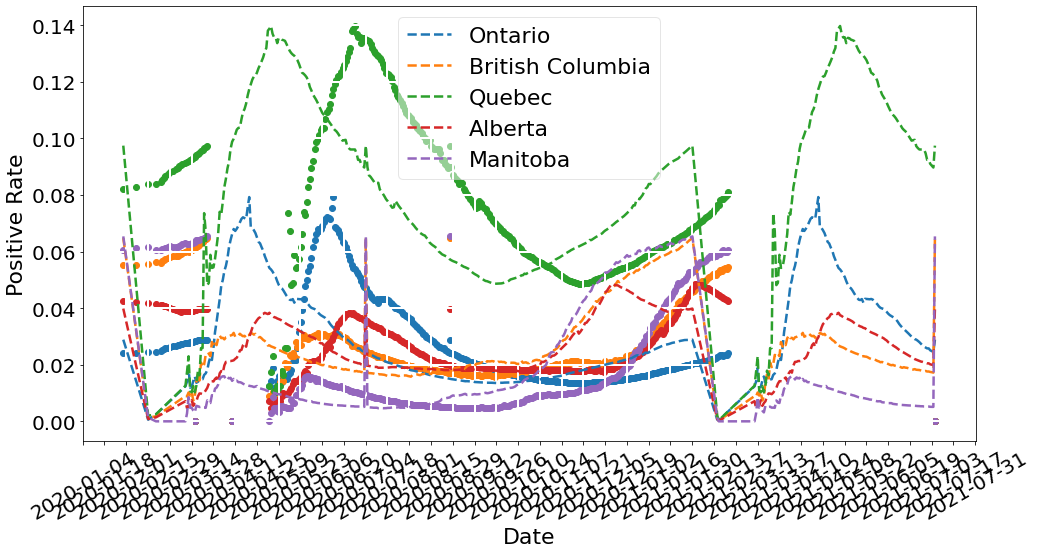

In [17]:
target_provinces = ['Ontario', 'British Columbia', 'Quebec', 'Alberta', 'Manitoba']
plot_rates(target_provinces, df_rates, "positive_rate", 'graphs/flights/positive_rates_provinces.png')

In [18]:
df_rates.to_csv('datasets/interpolated_positive_rates.csv', index=True, header=True)

In [19]:
# pd.read_csv('dataset/stable/interpolated_positive_rates.csv', index_col=0)